# Implementation of Age Detection


here we are doing prediction as s output we want numbers instead of range


In [1]:
# # Let's mount google drive into Colaboratory, so that data stored in drive can be used in Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # Let's unzip the data that we have presently in zipped format, in the below location

# !unzip "/content/drive/My Drive/wiki_crop.zip"              


In [3]:
# !pip install pandas

In [21]:
!pip install mlflow --quiet

In [22]:
import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

username:: rachana


token:c90d6e849df9e5f5024decdde31d82dd4a85619a
project name: age_detection

In [23]:
import scipy.io
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D
from keras.layers import Convolution2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.utils import shuffle
from keras.optimizers.legacy import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [24]:
mat = scipy.io.loadmat('/Users/rachana/Rachana_Python_VS/age_detection/wiki.mat')

# Reading Matlab files with SciPy

In [25]:
mat         # Matlab file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016',
 '__version__': '1.0',
 '__globals__': [],
 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
               dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                 array(['Dettmar Cramer'], dtype='<U14'),
                 array(['Marc Okrand'], dtype='<U11'), ...,
                 arr

## Data Collection and Transforamtion from mat file to dataframe

In [26]:
# Converting into pandas dataframe. Always easier and better to deal with :)

instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])

In [27]:
df.head()               # Lets see how exactly our dataset looks

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB


In [29]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) - timedelta(days=366)

    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [30]:
df['age'] = df['photo_taken'] - df['date_of_birth']          # Getting present age

In [31]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981,28
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925,39
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948,60
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930,31
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971,41


## Data Cleaning and Preprocessing

In [32]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#some guys seem to be greater than 100. Let's remove them and first make a model that classifies from 1 to 100
df = df[df['age'] <= 65]
 
#some guys seem to be unborn in the data set i.e age < 0
df = df[df['age'] >= 20]

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34885 entries, 0 to 62327
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                34885 non-null  int32  
 1   photo_taken        34885 non-null  uint16 
 2   full_path          34885 non-null  object 
 3   gender             34198 non-null  float64
 4   name               34885 non-null  object 
 5   face_location      34885 non-null  object 
 6   face_score         34885 non-null  float64
 7   second_face_score  0 non-null      float64
 8   date_of_birth      34885 non-null  int64  
 9   age                34885 non-null  int64  
dtypes: float64(3), int32(1), int64(2), object(3), uint16(1)
memory usage: 2.6+ MB


In [34]:
# Lower threshold for face_score - allows more images of poor quality (making the model more robust)

df = df[df['face_score'] >= 1.75]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [35]:
df.info()     # Only gender has null values. Since, this project deals with age estimation
              # only, we needn't worry about those. We would anyways be dropping gender
              # column after EDA (or at least won't be feeding it to the model)

<class 'pandas.core.frame.DataFrame'>
Index: 29752 entries, 0 to 62327
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          29752 non-null  int32  
 1   photo_taken  29752 non-null  uint16 
 2   full_path    29752 non-null  object 
 3   gender       29164 non-null  float64
 4   age          29752 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1), uint16(1)
memory usage: 1.1+ MB


In [36]:
df.head()

# GENDER: 0 - female , 1-male , NaN - unknown

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [37]:
df.describe()

,dob,photo_taken,gender,age
count,29752.000000,29752.000000,29164.000000,29752.000000
mean,717926.678509,2001.257495,0.742594,36.140293
std,8551.286016,19.976254,0.437213,12.232321
min,685555.000000,1940.000000,0.000000,20.000000
25%,713283.750000,2006.000000,0.000000,26.000000
50%,720385.500000,2010.000000,1.000000,33.000000
75%,724720.000000,2013.000000,1.000000,45.000000
max,729016.000000,2015.000000,1.000000,65.000000


In [38]:
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
df

,dob,photo_taken,full_path,gender,age,path
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg
...,...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31,38/9996938_1937-02-15_1968.jpg
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25,46/9996946_1943-11-01_1968.jpg
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26,49/9996949_1937-04-17_1963.jpg
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41,09/9998109_1972-12-27_2013.jpg


After looking at all data and their datatypes and cleaning the data, to get relevant columns,  lets analyze the data and its distribution, for better understanding of dataset.

## EDA (Exploratory Data Analysis)

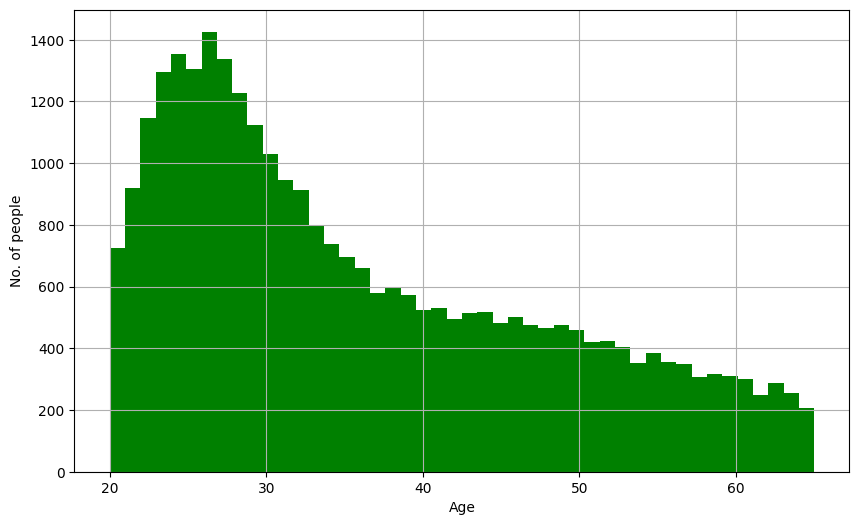

In [39]:
df['age'].hist(bins=df['age'].nunique(),color='g',figsize=(10,6))  

# Pretty obvious that a large chunk of population in training data is from 20 to 60. Sort of bell-shaped curve (Gaussian Distribution)-   very non uniform

plt.xlabel('Age')
plt.ylabel('No. of people')
plt.show()

Pretty obvious that a large chunk of population in training data is from 20 to 60. Sort of bell-shaped curve (Gaussian Distribution) -very non uniform.


Mean age is 38.492

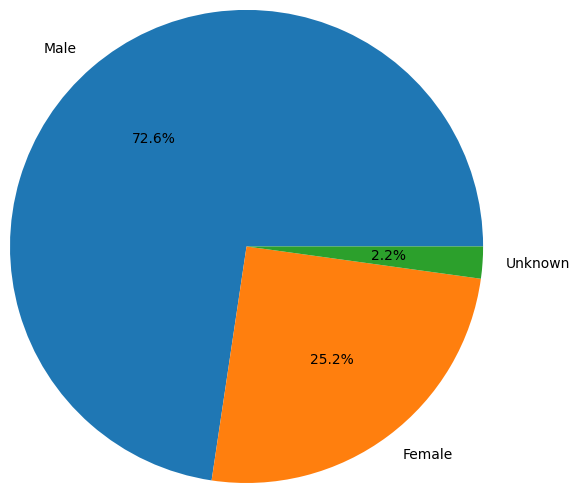

In [40]:
x1 = df[df['gender']==1]['gender'].count()
x2 = df[df['gender']==0]['gender'].count()
inp = [x1,x2,650]
lab = ['Male', 'Female', 'Unknown']

plt.pie(inp, labels=lab,radius=1.6,autopct='%.1f%%')
plt.show()

# Clearly, the dataset is heavily imbalanced in favour of males

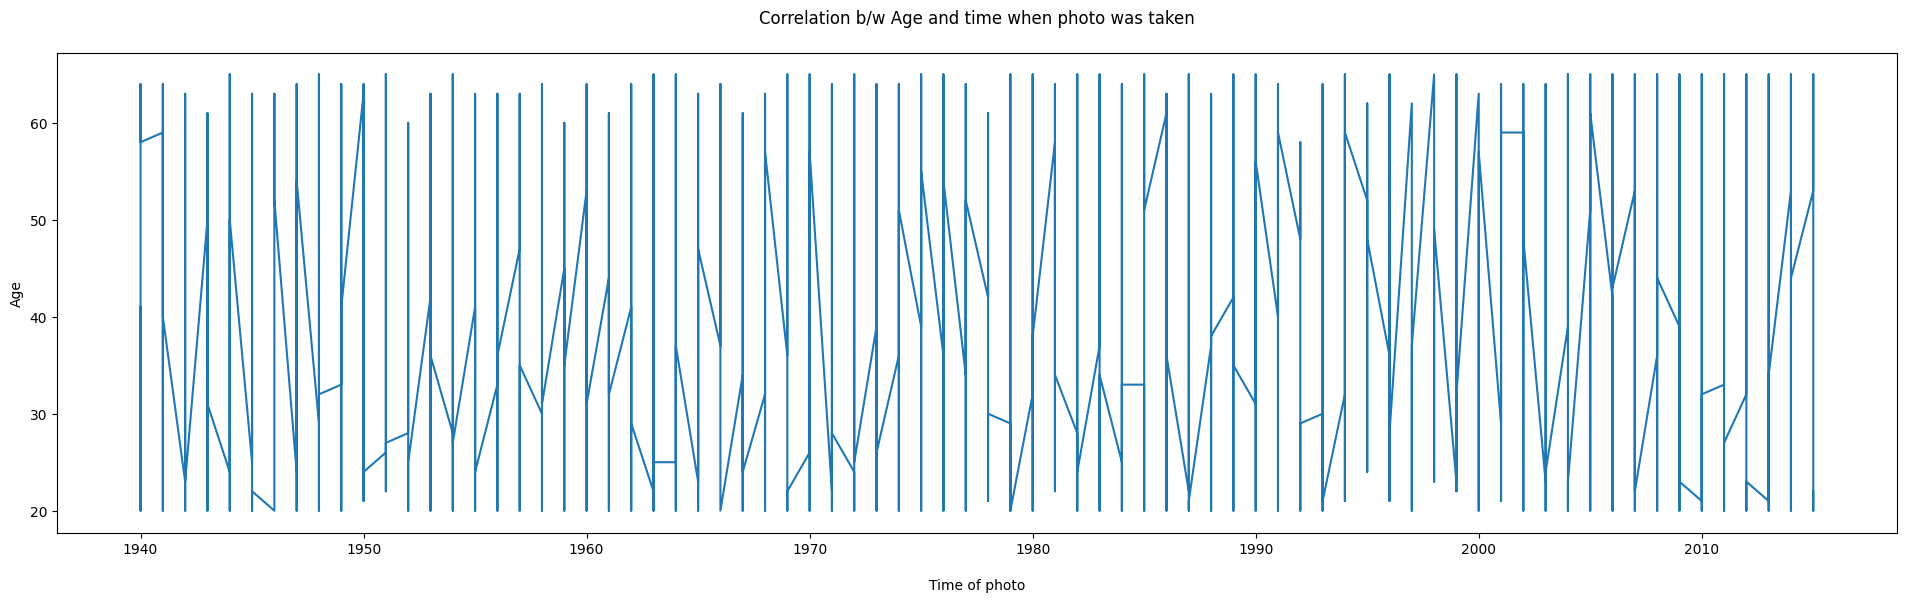

In [41]:
x = df.sort_values(by='photo_taken')

fig= plt.figure(figsize=(23,6))                        # width and height of plot in unit inches
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x['photo_taken'],x['age'])
plt.title('Correlation b/w Age and time when photo was taken\n')
plt.xlabel('\nTime of photo')
plt.ylabel('Age')
plt.show()

# Shows that irrespective of when photo was taken, almost always ppl between 20-70 have been covered.


The above graph, just tells us that people of different age groups were there irrespective of when the photo was taken. It does NOT tell us about the number of photos taken for each group. For that, let's plot the mean age for each year in which photo was taken

### Pixel based EDA on images

In [42]:
# For further EDA on images itself, we need to extract their pixel values. These pixel values won't have any use other than in EDA

target_size = (180, 180)
 
def get_image_pixel(image_path):
    pic = load_img("/Users/rachana/Rachana_Python_VS/age_detection/wiki/%s" % image_path[0],target_size=target_size)
    x = img_to_array(pic).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(get_image_pixel)

/Users/rachana/miniforge3/envs/moon/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


* Keras provides the `load_img()` function for loading an image from file as a 
PIL image object. 

The `load_img()` function provides additional arguments that may be useful when loading the image, such as **grayscale** that allows the image to be loaded in grayscale (defaults to False), **color_mode** that allows the image mode or channel format to be specified (defaults to rgb), and **target_size** that allows a tuple of (height, width) to be specified, resizing the image automatically after being loaded.


* Keras provides the `img_to_array()` function for converting a loaded image in PIL format into a NumPy array for use with deep learning models.

The numpy array essentially is the  pixel data.

In [25]:
df.head()

,dob,photo_taken,full_path,gender,age,path,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg,"[252.0, 252.0, 240.0, 253.0, 253.0, 241.0, 253..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg,"[91.0, 95.0, 96.0, 89.0, 93.0, 94.0, 88.0, 92...."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg,"[49.0, 8.0, 2.0, 49.0, 8.0, 2.0, 49.0, 8.0, 2...."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg,"[120.0, 101.0, 87.0, 116.0, 96.0, 85.0, 95.0, ..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg,"[198.0, 198.0, 200.0, 196.0, 195.0, 201.0, 194..."


In [43]:
x = df['age']           # We have 97 unique age values with us. 2,3,4 are missing
x = x.sort_values()
x.unique()

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [44]:
df['pixels'][0].size

# Each image now is 180 x 180 x 1. Hence has 32,400 pixels (NumPy array)

97200

In [ ]:
# # Here, we get the average pixel value for every image

# x = df.sort_values(by='age')
# x.reset_index(inplace=True)

# x['pixel_per_image'] = x['pixels']
# x['pixel_deviation_per_image'] = x['pixels']

# for i in range(34200):
#   x['pixel_per_image'][i] = x['pixels'][i].mean()
#   x['pixel_deviation_per_image'][i] = x['pixels'][i].max()-x['pixels'][i].min()

# x.head()

In [ ]:
# print(x['pixel_per_image'].min())          

# print(x['pixel_per_image'].max())

# print(x['pixel_per_image'].mean())     # Average pixel value across all images

7.9112244
241.59853
106.72448830409357


In [ ]:
# pip uninstall keras-preprocessing

In [ ]:
# pip install git+https://github.com/keras-team/keras-preprocessing.git -q

In [ ]:
# # Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

# def class_labels_reassign(age):

#     if 20 <= age <25:
#         return 0
#     elif 25 <= age < 30:
#         return 1
#     elif 30 <= age < 35:
#         return 2
#     elif 35 <= age < 40:
#         return 3
#     elif 40 <= age < 45:
#         return 4
#     elif 45 <= age < 50:
#         return 5
#     elif 50 <= age < 55:
#         return 6
#     elif 55 <= age < 60:
#         return 6
#     else:
#         return 7

In [ ]:
# df['ageclass'] = df['age'].map(class_labels_reassign)

In [ ]:
df

,dob,photo_taken,full_path,gender,age,path,pixels,ageclass
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,17/10000217_1981-05-05_2009.jpg,"[252.0, 252.0, 240.0, 253.0, 253.0, 241.0, 253...",1
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,12/100012_1948-07-03_2008.jpg,"[91.0, 95.0, 96.0, 89.0, 93.0, 94.0, 88.0, 92....",6
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,16/10002116_1971-05-31_2012.jpg,"[49.0, 8.0, 2.0, 49.0, 8.0, 2.0, 49.0, 8.0, 2....",4
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,02/10002702_1960-11-09_2012.jpg,"[120.0, 101.0, 87.0, 116.0, 96.0, 85.0, 95.0, ...",6
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,41/10003541_1937-09-27_1971.jpg,"[198.0, 198.0, 200.0, 196.0, 195.0, 201.0, 194...",2
...,...,...,...,...,...,...,...,...
62321,707521,1968,[38/9996938_1937-02-15_1968.jpg],1.0,31,38/9996938_1937-02-15_1968.jpg,"[71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71.0, 71....",2
62322,709971,1968,[46/9996946_1943-11-01_1968.jpg],1.0,25,46/9996946_1943-11-01_1968.jpg,"[57.0, 57.0, 57.0, 43.0, 43.0, 43.0, 68.0, 68....",1
62323,707582,1963,[49/9996949_1937-04-17_1963.jpg],1.0,26,49/9996949_1937-04-17_1963.jpg,"[48.0, 48.0, 48.0, 46.0, 46.0, 46.0, 47.0, 47....",1
62325,720620,2013,[09/9998109_1972-12-27_2013.jpg],1.0,41,09/9998109_1972-12-27_2013.jpg,"[142.0, 176.0, 100.0, 142.0, 176.0, 100.0, 142...",4


## Image Data Generator

Image Data Generator is used to artificially expand a dataset by creating modified versions of images or other data points.It is a powerful technique that can help improve the performance, generalization, and robustness of machine learning models

**Note: Only augment images in train set. Validation/test set images must not be augmented.**

In [45]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into train and test
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [46]:
train_datagen=ImageDataGenerator(rescale=1./255.,                # IDG instance
                           rotation_range=25,
                           brightness_range=[0.7,1.3],
                           zoom_range=0.5,
                           horizontal_flip=True)    


valid_datagen=ImageDataGenerator(rescale=1./255.)                # IDG instance
                           

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='/Users/rachana/Rachana_Python_VS/age_detection/wiki',
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="/Users/rachana/Rachana_Python_VS/age_detection/wiki",
    x_col="path",
    y_col="age",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(180,180))

Found 23801 validated image filenames.
Found 5951 validated image filenames.


In [30]:
len(train_generator)

372

## Model Architecture
Age estimation is a regression problem. 


In [ ]:
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import SpatialDropout2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l1_l2

input_shape = (180, 180, 3)
inputs = Input(shape=input_shape)

x = SeparableConv2D(64, (3, 3), padding="same")(inputs)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.15)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.30)(x)
x = BatchNormalization()(x)

x = Dense(64)(x)
x = Activation("relu")(x)
x = Dropout(0.20)(x)
x = BatchNormalization()(x)

x = Dense(1)(x)
x = Activation("relu")(x)           # linear also works. But relu is better

age_model = Model(inputs=inputs, outputs=x)

In [ ]:
age_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 separable_conv2d (Separabl  (None, 180, 180, 64)      283       
 eConv2D)                                                        
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 90, 90, 64)        256       
 Normalization)                                                  
                                                             

In [31]:
age_model.compile(loss='mse', optimizer='Adam', metrics=['mae','mse'])

NameError: name 'age_model' is not defined

In [32]:
filepath='/Users/rachana/Rachana_Python_VS/age_gender/model/agemodelp.h5'
from keras import callbacks
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# Train the model
history = age_model.fit(
    train_generator,
    epochs=60,
    validation_data=valid_generator,
    callbacks=[ checkpoint]
)


Epoch 1/60
372/372 [==============================] - ETA: 0s - loss: 298.3463 - mae: 11.9568 - mse: 298.3463
Epoch 1: val_loss improved from 222.84854 to 130.74478, saving model to /Users/rachana/Rachana_Python_VS/age_gender/model/agemodelp.h5
372/372 [==============================] - 258s 694ms/step - loss: 298.3463 - mae: 11.9568 - mse: 298.3463 - val_loss: 130.7448 - val_mae: 9.3585 - val_mse: 130.7448
Epoch 2/60
372/372 [==============================] - ETA: 0s - loss: 140.8431 - mae: 9.7716 - mse: 140.8431
Epoch 2: val_loss did not improve from 130.74478
372/372 [==============================] - 256s 686ms/step - loss: 140.8431 - mae: 9.7716 - mse: 140.8431 - val_loss: 135.9767 - val_mae: 9.2208 - val_mse: 135.9767
Epoch 3/60
372/372 [==============================] - ETA: 0s - loss: 134.6801 - mae: 9.5309 - mse: 134.6801
Epoch 3: val_loss improved from 130.74478 to 129.15985, saving model to /Users/rachana/Rachana_Python_VS/age_gender/model/agemodelp.h5
372/372 [=============

In [ ]:
# from keras.optimizers.legacy import Adam

# from keras.callbacks import LearningRateScheduler
# #import math

# # def step_decay(epoch):
# # 	initial_lrate = 0.008
# # 	drop = 0.7
# # 	epochs_drop = 12.0
# # 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# # 	return lrate      
# from keras import callbacks
# # opt = Adam(learning_rate=0.01)
# # lrate = LearningRateScheduler(step_decay)
# # callbacks_list = [lrate]
# filepath='/Users/rachana/Rachana_Python_VS/age_gender/model/agemodel.h5'
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# age_model.compile(loss='mse', optimizer='Adam', metrics=['mae','mse'])

# STEP_SIZE_TRAIN= len(train_generator)//32
# STEP_SIZE_VALID= len(valid_generator)//32

# history = age_model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator,
#                      validation_steps=STEP_SIZE_VALID, callbacks=checkpoint, epochs=100)
  

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Total loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()        

<Figure size 640x480 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean absolute error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mse'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mse'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean squared error',
                  xaxis_title='Epoch',
                  yaxis_title='mse')


fig.show()

<Figure size 640x480 with 0 Axes>

Clearly, there is still lot of scope for improvement - no saturation in performance yet. Both val & train performance seems to be improving in *mae*, *mse*.
Let's train some more

In [ ]:
history = age_model.fit_generator(generator=train_generator, validation_data=valid_generator,
                     callbacks=checkpoint, epochs=40)
  

/var/folders/b2/8x1qqknd4818g7hylzxv20yr0000gq/T/ipykernel_49490/2039079393.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/40
212/372 [================>.............] - ETA: 1:51 - loss: 98.9957 - mae: 7.9929 - mse: 98.9957

/Users/rachana/miniforge3/envs/moon/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:870: UserWarning:

Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 



372/372 [==============================] - ETA: 0s - loss: 99.2733 - mae: 7.9932 - mse: 99.2733
Epoch 1: val_loss did not improve from 92.97044
372/372 [==============================] - 273s 731ms/step - loss: 99.2733 - mae: 7.9932 - mse: 99.2733 - val_loss: 97.5917 - val_mae: 7.8622 - val_mse: 97.5917
Epoch 2/40
372/372 [==============================] - ETA: 0s - loss: 99.4189 - mae: 8.0082 - mse: 99.4189
Epoch 2: val_loss did not improve from 92.97044
372/372 [==============================] - 247s 663ms/step - loss: 99.4189 - mae: 8.0082 - mse: 99.4189 - val_loss: 93.3525 - val_mae: 7.5963 - val_mse: 93.3525
Epoch 3/40
372/372 [==============================] - ETA: 0s - loss: 98.5780 - mae: 7.9843 - mse: 98.5780
Epoch 3: val_loss did not improve from 92.97044
372/372 [==============================] - 240s 645ms/step - loss: 98.5780 - mae: 7.9843 - mse: 98.5780 - val_loss: 103.7851 - val_mae: 8.1234 - val_mse: 103.7851
Epoch 4/40
372/372 [==============================] - ETA: 0s

/Users/rachana/miniforge3/envs/moon/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



372/372 [==============================] - ETA: 0s - loss: 97.6848 - mae: 7.9202 - mse: 97.6848
Epoch 8: val_loss did not improve from 91.20382
372/372 [==============================] - 240s 643ms/step - loss: 97.6848 - mae: 7.9202 - mse: 97.6848 - val_loss: 99.4384 - val_mae: 7.8244 - val_mse: 99.4384
Epoch 9/40
372/372 [==============================] - ETA: 0s - loss: 97.0652 - mae: 7.8918 - mse: 97.0652
Epoch 9: val_loss did not improve from 91.20382
372/372 [==============================] - 234s 627ms/step - loss: 97.0652 - mae: 7.8918 - mse: 97.0652 - val_loss: 91.2335 - val_mae: 7.4814 - val_mse: 91.2335
Epoch 10/40
372/372 [==============================] - ETA: 0s - loss: 97.2037 - mae: 7.8958 - mse: 97.2037
Epoch 10: val_loss did not improve from 91.20382
372/372 [==============================] - 233s 626ms/step - loss: 97.2037 - mae: 7.8958 - mse: 97.2037 - val_loss: 107.2409 - val_mae: 7.9478 - val_mse: 107.2409
Epoch 11/40
372/372 [==============================] - ETA:

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val Total loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')


fig.show()
     

<Figure size 640x480 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mae'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean absolute error',
                  xaxis_title='Epoch',
                  yaxis_title='mae')


fig.show()
     

<Figure size 640x480 with 0 Axes>

In [ ]:
import plotly.graph_objects as go

plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['mse'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_mse'],
                    name='Validation'))


fig.update_layout(height=500, 
                  width=700,
                  title='Train vs Val mean squared error',
                  xaxis_title='Epoch',
                  yaxis_title='mse')


fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
history = age_model.fit_generator(generator=train_generator, validation_data=valid_generator,
                     callbacks=checkpoint, epochs=15)

/var/folders/b2/8x1qqknd4818g7hylzxv20yr0000gq/T/ipykernel_49490/4030523978.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/15
372/372 [==============================] - ETA: 0s - loss: 92.0259 - mae: 7.6698 - mse: 92.0259
Epoch 1: val_loss did not improve from 87.78877
372/372 [==============================] - 310s 830ms/step - loss: 92.0259 - mae: 7.6698 - mse: 92.0259 - val_loss: 101.9656 - val_mae: 7.9251 - val_mse: 101.9656
Epoch 2/15
372/372 [==============================] - ETA: 0s - loss: 91.9665 - mae: 7.6483 - mse: 91.9665
Epoch 2: val_loss did not improve from 87.78877
372/372 [==============================] - 230s 617ms/step - loss: 91.9665 - mae: 7.6483 - mse: 91.9665 - val_loss: 95.1761 - val_mae: 7.7927 - val_mse: 95.1761
Epoch 3/15
372/372 [==============================] - ETA: 0s - loss: 91.7295 - mae: 7.6505 - mse: 91.7295
Epoch 3: val_loss did not improve from 87.78877
372/372 [==============================] - 299s 804ms/step - loss: 91.7295 - mae: 7.6505 - mse: 91.7295 - val_loss: 88.0676 - val_mae: 7.4157 - val_mse: 88.0676
Epoch 4/15
372/372 [==============================

In [37]:
loaded_model = load_model('/Users/rachana/Rachana_Python_VS/age_detection/model/agemodelpf.h5')
filepath='/Users/rachana/Rachana_Python_VS/age_gender/model/agemodelpfloaded+60.h5'
from keras import callbacks
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [38]:
loaded_model.compile(loss='mse', optimizer='Adam', metrics=['mae','mse'])

In [1]:
history = loaded_model.fit_generator(generator=train_generator, validation_data=valid_generator,
                     callbacks=checkpoint, epochs=60)

NameError: name 'loaded_model' is not defined

In [ ]:
age_model.save('/Users/rachana/Rachana_Python_VS/age_detection/model/agemodelpfloaded+60f.h5')

In [ ]:
test_loss, test_mae, test_mse = age_model.evaluate(valid_generator)

93/93 [==============================] - 26s 270ms/step - loss: 105.9266 - mae: 8.3534 - mse: 105.9266


validation performance better than training performance because, recall that we did heavy augmentation in training dataset, so that model never sees the same image twice. The augmented images initially make it difficult for the model to learn, but are very beneficial in the long run. They improve the model's generalization ability (ability to be more robust and the make accurate predictions on unseen images/data).There was no augmentation in validation set at all. Obviously model sees the same image multiple times over all these epochs during the validation process.

## Age Estimation based on Provided Image


In [47]:
#Load saved model
new_model = load_model('/Users/rachana/Rachana_Python_VS/age_detection/model/agemodelpf.h5')
 

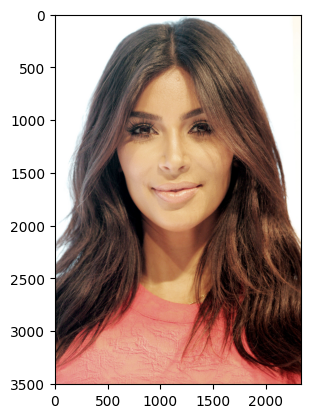

1/1 [==============================] - 0s 251ms/step
[[40.570385]]


In [48]:
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/Users/rachana/Rachana_Python_VS/age_detection/images/Kim_Kardashian_West_2014_34.jpeg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = new_model.predict(loadImage(picture))
print(prediction)


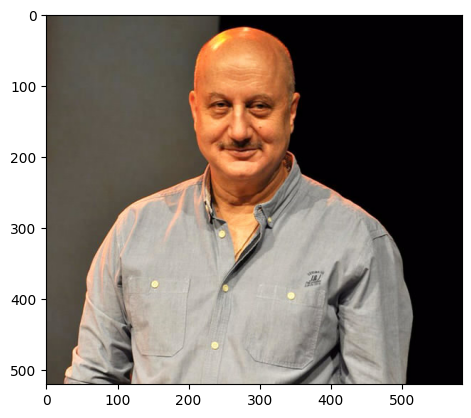

1/1 [==============================] - 0s 34ms/step
[[54.119446]]


In [14]:
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(180, 180))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/Users/rachana/Rachana_Python_VS/age_detection/images/AnupamKher5_58.jpeg"                                  
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()

prediction = new_model.predict(loadImage(picture))
print(prediction)
